In [1]:
import numpy as np
import os
from skimage.io import imread
from scipy.ndimage import laplace
import matplotlib.pyplot as plt

In [2]:
## 2023_12_08 Tweez pLPT20 Pos 12
log_params = {"A": 12.088146207782815, "mu_m": 0.029873451091405774, "lambda": 12.552141222237253}
incubation_time = 4.8166 * 60 * 60 # pos 12
offset = incubation_time / 60 / 10
def logistic_growth_rate(t, log_params):
    # Convert time to seconds and add incubation time
    t = (t + incubation_time) / 60
    A = log_params['A']
    mu_m = log_params['mu_m']
    l = log_params['lambda']
    gr = 4 * mu_m * np.exp(4 * mu_m / A * (l - t) + 2) / (1 + np.exp(4 * mu_m / A * (l - t) + 2))**2
    return gr / 60

def logistic(t, log_params):
    # Convert time to seconds and add incubation time
    t = (t + incubation_time) / 60
    A = log_params['A']
    mu_m = log_params['mu_m']
    l = log_params['lambda']
    log_B = A / (1 + np.exp(4 * mu_m / A * (l - t) + 2))
    return np.exp(log_B)

In [3]:
#path_ext = '/Users/timrudge/Pictures/Analyzed files' # 
path_ext = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files'
folder_results = 'results'
folder_velocity = 'velocity_data'

scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
dnas = {'pLPT20&pLPT41': 'pLPT20&41', 'pLPT119&pLPT41': 'pLPT119&41', 'pAAA': 'pAAA', 'pLPT107&pLPT41': 'pLPT107&41'}

exp_date = '2023_12_08'
#vector = 'pAAA'
#vector = 'pLPT107&pLPT41'
vector = 'pLPT20&pLPT41'
#vector = 'pLPT119&pLPT41'

#scope_name = 'Ti scope'
scope_name = 'Tweez scope'
pos = 12

if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
    yfp_chn = 0
    cfp_chn = 1
    ph_chn = 2
    fluo_chns = 2
else:
    rfp_chn = 0
    yfp_chn = 1
    cfp_chn = 2
    ph_chn = 3
    fluo_chns = 3

path_scope = os.path.join(path_ext, scope_name)
path = os.path.join(path_scope, exp_date)
path_results = os.path.join(path,folder_results, f"pos{pos}")
path_velocity = os.path.join(path,folder_velocity, f"pos{pos}")

fname = f'{exp_date}_10x_1.0x_{dnas[vector]}_{scopes[scope_name]}_Pos{pos}.ome.tif'
fname

'2023_12_08_10x_1.0x_pLPT20&41_TiTweez_Pos12.ome.tif'

In [4]:
tf = 316
edt = np.load(os.path.join(path_results,'edt.npy'))[:tf,:,:]
nt,nx,ny = edt.shape
print(edt.shape)

(316, 1024, 1024)


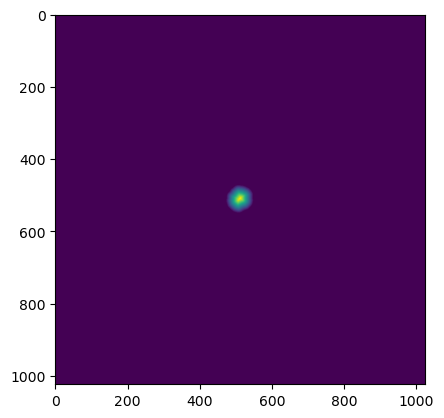

In [5]:
plt.imshow(edt[0,:,:])

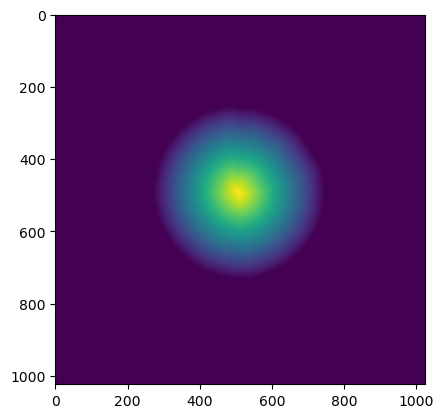

In [6]:
plt.imshow(edt[-1,:,:])

In [7]:
im = imread(os.path.join(path,fname))
print(im.shape)
#im = im[:,:,:,[2,3,1]]
im = im[:tf,:,:,:ph_chn].astype(float)
print(im.shape)

(406, 1024, 1024, 3)
(316, 1024, 1024, 2)


In [8]:
from scipy.ndimage import gaussian_filter

# Background correction
nt,nx,ny,nc = im.shape
bg = im[:,-256:,-256:,:].mean(axis=(1,2))
bgvar = im[:,-256:,-256:,:].var(axis=(1,2))

for t in range(nt):
    for c in range(nc):
        im[t,:,:,c] = gaussian_filter(im[t,:,:,c], 1) - bg[t,c]

im[im<0] = 0

In [9]:
y,x = np.meshgrid(np.arange(nx), np.arange(ny))
edt0 = edt[-1,:,:]
minx = x[edt0>0].min()
maxx = x[edt0>0].max()
miny = y[edt0>0].min()
maxy = y[edt0>0].max()
w = maxx - minx
h = maxy - miny
w = int(w//2) * 2
h = int(h//2) * 2

print(w,h)
pad = 256

crop_edt = np.zeros((nt,w+2*pad,h+2*pad))
crop_im = np.zeros((nt,w+2*pad,h+2*pad,2))
print(crop_edt.shape)

for t in range(nt):
    tedt = edt[t,:,:]
    tim = im[t,:,:,:]
    cx = int(x[tedt>0].mean())
    cy = int(y[tedt>0].mean())
    
    xl, xu = cx - w//2 - pad, cx + w//2 + pad
    yl, yu = cy - h//2 - pad, cy + h//2 + pad
    if xl < 0:
        xu = xu + np.abs(xl)
        xl = 0
    #print(f"xlow: {xl}, xhigh: {xu}")
    #print(f"ylow: {yl}, xhigh: {yu}")
    
    crop_edt[t,:,:] = tedt[xl:xu, yl:yu]
    crop_im[t,:,:] = tim[xl:xu, yl:yu,:]

476 470
(316, 988, 982)


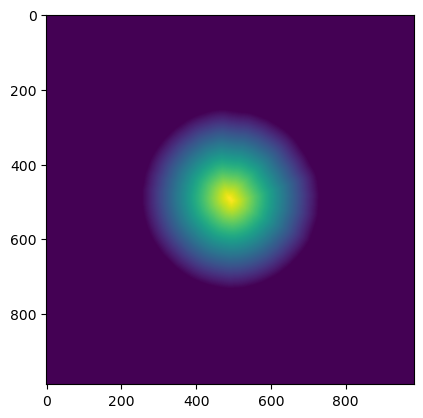

In [10]:
plt.imshow(crop_edt[315,:,:])

#### Diffusion

In [11]:
nt,nx,ny = crop_edt.shape
offset = incubation_time / 60 / 10
ntt = nt + int(offset)
crop_edt = np.zeros((ntt,nx,ny))
y,x = np.meshgrid(np.arange(ny), np.arange(nx))
cx,cy = nx/2, ny/2
R = np.sqrt((x-cx)**2 + (y-cy)**2)
area_all = np.zeros(ntt)
for t in range(ntt):
    area = logistic(t * 10 * 60 - offset * 10 * 60, log_params)
    area_all[t] = area
    radius = np.sqrt(area / np.pi)
    crop_edt[t,:,:] = radius - R
    tedt = crop_edt[t,:,:]
    tedt[tedt<0] = 0 
    crop_edt[t,:,:] = tedt
np.save(os.path.join(path_results,'diff_area_all_fp_only.npy'),area_all)

In [12]:
def split_image_into_blocks(img, block_size):
    img_array = np.array(img)

    # Get the dimensions of the image
    nt, height, width, channels = img_array.shape

    # Calculate the number of blocks along the height and width
    num_blocks_y = height // block_size
    num_blocks_x = width // block_size

    # Create an array to hold the blocks
    blocks = np.zeros((nt, num_blocks_y, num_blocks_x, block_size, block_size, channels))

    # Extract blocks and store them in the array
    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            for c in range(channels):
                for t in range(nt):
                    blocks[t, i, j, :, :, c] = img_array[t, i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size, c]
    return blocks

def split_edt_into_blocks(img, block_size):
    img_array = np.array(img)

    # Get the dimensions of the image
    nt, height, width = img_array.shape

    # Calculate the number of blocks along the height and width
    num_blocks_y = height // block_size
    num_blocks_x = width // block_size

    # Create an array to hold the blocks
    blocks = np.zeros((nt, num_blocks_y, num_blocks_x, block_size, block_size))

    # Extract blocks and store them in the array
    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            for t in range(nt):
                blocks[t, i, j, :, :] = img_array[t, i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size]
    return blocks

In [13]:
edt_blocks = split_edt_into_blocks(crop_edt, 16)
del crop_edt

In [14]:
im_blocks = split_image_into_blocks(crop_im, 16)
del crop_im

In [15]:
crop_edt_low = edt_blocks.mean(axis=(3,4))
crop_im_low = im_blocks.mean(axis=(3,4))
print(crop_im_low.shape)

(316, 61, 61, 2)


In [16]:
#from skimage.transform import downscale_local_mean

#print(crop_edt.shape)
#crop_edt_low = np.zeros((ntt,60,60))
#crop_im_low = np.zeros((nt,60,60,2))

#for t in range(ntt):
#    edt_low = downscale_local_mean(crop_edt[t,:,:], (16,16))
#    crop_edt_low[t,:,:] = edt_low

#for t in range(nt):
#    im_low = downscale_local_mean(crop_im[t,:,:], (16,16,1))
#    crop_im_low[t,:,:] = im_low

crop_edt = crop_edt_low
crop_im = crop_im_low
print(crop_edt.shape)
ntt,nx,ny = crop_edt.shape
nt,nx,ny,nc = crop_im.shape

crop_im[crop_edt[int(offset):,:,:]==0] = np.nan

(344, 61, 61)


In [17]:
np.save(os.path.join(path_results, 'diff_crop_edt_fp_only.npy'), crop_edt)
np.save(os.path.join(path_results, 'diff_crop_im_fp_only.npy'), crop_im)

In [18]:
u0 = np.zeros((nx,ny)) + 1
def dudt(u, t, tmask, phi, kappa, gamma, dx, t0):
    du = np.zeros((nx,ny))
    #du[tmask] += phi * 1 / (1 + np.exp((t - t0) / dt)) # * np.exp(-t * 1e-6)
    u = u.reshape((nx,ny))
    delu = laplace(u, mode='constant', cval=1)
    du += kappa * delu / dx / dx
    #du[tmask] -= gamma * u[tmask] * 1 / (1 + np.exp((t - t0) / dt))
    gr = logistic_growth_rate(t - offset * 10 * 60, log_params)
    du[tmask] -= gamma * u[tmask] * gr
    return du.ravel()

In [19]:
def hill(x, K, n):
    xx = (x/K)**n
    return xx/(1 + xx)

#p0 = np.zeros((nx,ny,3)) + 1 # np.random.uniform(size=(nx,ny,3))
#def dpdt(p, t, tmask, uu, alpha1, alpha2, alpha3, alpha4, K, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp):
#    #G -| R -| B
#    p = p.reshape((nx,ny,4))
#    dpdt = np.zeros_like(p)
#    dpdt[:,:,0] = hill(uu, KK0, nn) / hill(1, KK0, nn) * alpha1 / (1 + (p[:,:,2]/K)**n) - gamma_repr * p[:,:,0]
#    dpdt[:,:,1] = hill(uu, KK1, nn) / hill(1, KK1, nn) * alpha2 / (1 + (p[:,:,0]/K)**n) - gamma_repr * p[:,:,1]
#    dpdt[:,:,2] = hill(uu, KK2, nn) / hill(1, KK2, nn) * alpha3 / (1 + (p[:,:,1]/K)**n) - gamma_repr * p[:,:,2]
#    dpdt[:,:,3] = hill(uu, KK3, nn) / hill(1, KK3, nn) * alpha4 - gamma_repr * p[:,:,3]
#    #dpdt[:,:,3] = km0 * p[:,:,0] - gamma_fp * p[:,:,3]
#    #dpdt[:,:,4] = km1 * p[:,:,1] - gamma_fp * p[:,:,4]
#    #dpdt[:,:,5] = km2 * p[:,:,2] - gamma_fp * p[:,:,5]
#    for c in range(3):
#        cdpdt = dpdt[:,:,c]
#        cdpdt[tmask==0] = 0
#        dpdt[:,:,c] = cdpdt
#    return dpdt.ravel()

def shill(x, K, n):
    return 0.5 + n * (x - K) / 4 / K - n * (x - K)**2 / 8 / K / K

def hill(x, K, n):
    xx = (x/K)**n
    return xx/(1 + xx)

def nhill(x, K, n):
    xx = (x/K)**n
    return xx/(1 + xx) * (1 + K**n)

def step(x, K):
    return (x > K) * 1

def hill2(x, rep, Ku, Krep, nu, nrep):
    return (x/Ku)**nu / (1 + (x/Ku)**nu + (rep/Krep)**nrep)
    
p0 = np.zeros((nx,ny,3)) + 1 # np.random.uniform(size=(nx,ny,3))
def dpdt(p, t, tmask, uu, alpha1, alpha2, alpha3, alpha4, alpha5, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp0, gamma_fp1):
    #G -| R -| B
    p = p.reshape((nx,ny,5))
    dpdt = np.zeros_like(p)
    # LacI
    #dpdt[:,:,0] = step(uu, KK0) * alpha1 / (1 + (p[:,:,2]/K2)**n) - gamma_repr * p[:,:,0]
    #dpdt[:,:,0] = nhill(uu, KK0, nn) * alpha1 / (1 + (p[:,:,2]/K2)**n) - gamma_repr * p[:,:,0]
    dpdt[:,:,0] = alpha1 / (1 + (p[:,:,2]/K2)**n) - gamma_repr * p[:,:,0]
    #dpdt[:,:,0] = hill2(uu, p[:,:,2], KK0, K2, nn, n) * alpha1 - gamma_repr * p[:,:,0]
    # TetR
    #dpdt[:,:,1] = step(uu, KK1) * alpha2 / (1 + (p[:,:,0]/K0)**n) - gamma_repr * p[:,:,1]
    #dpdt[:,:,1] = nhill(uu, KK1, nn) * alpha2 / (1 + (p[:,:,0]/K0)**n) - gamma_repr * p[:,:,1]
    dpdt[:,:,1] = alpha2 / (1 + (p[:,:,0]/K0)**n) - gamma_repr * p[:,:,1]
    #dpdt[:,:,1] = hill2(uu, p[:,:,0], KK1, K0, nn, n) * alpha2 - gamma_repr * p[:,:,1]
    # cI
    #dpdt[:,:,2] = step(uu, KK2) * alpha3 / (1 + (p[:,:,1]/K1)**n) - gamma_repr * p[:,:,2]
    #dpdt[:,:,2] = nhill(uu, KK2, nn) * alpha3 / (1 + (p[:,:,1]/K1)**n) - gamma_repr * p[:,:,2]
    dpdt[:,:,2] = alpha3 / (1 + (p[:,:,1]/K1)**n) - gamma_repr * p[:,:,2]
    #dpdt[:,:,2] = hill2(uu, p[:,:,1], KK2, K1, nn, n) * alpha3 - gamma_repr * p[:,:,2]
    # mVenus
    #dpdt[:,:,2] = step(uu, KK2) * alpha3 / (1 + (p[:,:,1]/K1)**n) - gamma_repr * p[:,:,2]
    #dpdt[:,:,2] = nhill(uu, KK2, nn) * alpha3 / (1 + (p[:,:,1]/K1)**n) - gamma_repr * p[:,:,2]
    dpdt[:,:,3] = alpha4 / (1 + (p[:,:,1]/K1)**n) - gamma_fp0 * p[:,:,3]
    #dpdt[:,:,2] = hill2(uu, p[:,:,1], KK2, K1, nn, n) * alpha3 - gamma_repr * p[:,:,2]
    # mCFP
    #dpdt[:,:,3] = step(uu, KK3) * alpha4 - gamma_repr * p[:,:,3]
    #dpdt[:,:,3] = nhill(uu, KK3, nn) * alpha4 - gamma_repr * p[:,:,3]
    dpdt[:,:,4] = alpha5 - gamma_fp1 * p[:,:,4]
    
    #dpdt[:,:,3] = km0 * p[:,:,0] - gamma_fp * p[:,:,3]
    #dpdt[:,:,4] = km1 * p[:,:,1] - gamma_fp * p[:,:,4]
    #dpdt[:,:,5] = km2 * p[:,:,2] - gamma_fp * p[:,:,5]
    for c in range(5):
        cdpdt = dpdt[:,:,c]
        cdpdt[tmask==0] = 0
        dpdt[:,:,c] = cdpdt
    return dpdt.ravel()



In [20]:
from scipy.integrate import odeint
def solve_gene_expression(rep00, rep01, rep02, u, alpha0, alpha1, alpha2, alpha3, alpha4, beta0, beta1, beta2, beta3, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp0, gamma_fp1, h, ts):
    nt = len(ts)
    print(nt)
    t0 = int(ts[0] * dt)
    p0 = crop_im[int(t0 / 60 / 10),:,:,:]
    p = np.zeros((nt+1,nx,ny,5))
    p[0,:,:,0] = rep00
    p[0,:,:,1] = rep01
    p[0,:,:,2] = rep02
    p[0,:,:,3] = p0[:,:,0]    
    p[0,:,:,4] = p0[:,:,1]
    mask = np.zeros((nt+1,nx,ny))
    mask[0,:,:] = crop_edt[int(t0 / 60 / 10 + offset),:,:]>0 # crop_edt[0,:,:]>0
    for ti in range(nt):
        t = int(ts[ti] * dt)
        tmask = crop_edt[int(t / 60 / 10 + offset),:,:] # crop_edt[0,:,:]
        phi0 = alpha0 #* hill(u[ti,:,:], KK0, nn) + beta0
        phi1 = alpha1 #* hill(u[ti,:,:], KK1, nn) + beta1
        phi2 = alpha2 #* hill(u[ti,:,:], KK2, nn) + beta2
        phi3 = alpha3 * (hill(u[ti,:,:], KK2, nn) + beta2)
        phi4 = alpha4 * hill(u[ti,:,:], KK3, nn) + beta3
        dp = dpdt(p[ti,:,:,:], t, tmask>0, u[ti,:,:], phi0, phi1, phi2, phi3 * h, phi4 * h, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp0, gamma_fp1)
        p[ti+1,:,:,:] = p[ti,:,:,:] + dt * dp.reshape(nx,ny,5)
        mask[ti+1,:,:] = tmask
    
    #p[:-1,:,:,0] = hill(u, KK0, nn) * p[:-1,:,:,0]
    #p[:-1,:,:,1] = hill(u, KK1, nn) * p[:-1,:,:,1]
    #p[:-1,:,:,2] = hill(u, KK2, nn) * p[:-1,:,:,2]
    #p[:-1,:,:,3] = hill(u, KK2, nn) * p[:-1,:,:,3]
    pmask = np.zeros_like(p) + np.nan
    for c in range(5):
        cp = p[:,:,:,c]
        cpmask = pmask[:,:,:,c]
        cpmask[mask>0] = cp[mask>0]
        pmask[:,:,:,c] = cpmask
    return pmask

def solve_diffusion(kappa, gamma, dx, dt, t0, ts):
    nt = len(ts)
    print(nt)
    u = np.zeros((nt+1,nx,ny))
    u[0,:,:] = u0
    mask = np.zeros((nt+1,nx,ny))
    mask[0,:,:] = crop_edt[0,:,:]>0
    for ti in range(nt):
        t = int(ts[ti] * dt)
        tmask = crop_edt[int(t / 60 / 10),:,:] # crop_edt[0,:,:]
        du = dudt(u[ti,:,:], t, tmask>0, 0, kappa, gamma, dx, t0)
        u[ti+1,:,:] = u[ti,:,:] + dt * du.reshape(nx,ny)
        mask[ti+1,:,:] = tmask

    umask = np.zeros_like(u) + np.nan
    umask[mask>0] = u[mask>0]
    return umask

In [21]:
from scipy.signal import savgol_filter

def compute_dlog(x, w=21):
    return savgol_filter(np.log(x), w, 3, deriv=1, axis=0)

def compute_rho(x, y, w=21):
    rho_01 = x / y # pmask[:,:,:,0] / pmask[:,:,:,1]
    #rho_02 = pmask[:,:,:,0] / pmask[:,:,:,2]
    #rho_12 = pmask[:,:,:,1] / pmask[:,:,:,2]

    lrho_01 = np.log(rho_01)
    dslrho_01 = savgol_filter(lrho_01, w, 3, deriv=1, axis=0)
    #lrho_02 = np.log(rho_02)
    #dslrho_02 = savgol_filter(lrho_02, w, 3, deriv=1, axis=0)
    #lrho_12 = np.log(rho_12)
    #dslrho_12 = savgol_filter(lrho_12, w, 3, deriv=1, axis=0)

    #return rho_01,rho_02,rho_12, dslrho_01,dslrho_02,dslrho_12
    return rho_01,dslrho_01

In [22]:
from scipy.interpolate import interp1d

def residuals(x):
    print(np.exp(x))
    ha, kappa, gamma_fp0, gamma_fp1, alpha0, alpha1, beta2, beta3, gamma, K0, K1, K2, gamma_repr, rep00, rep01, rep02, KK2, KK3, nn = np.exp(x)
    ts = np.arange(0, np.floor(36 * 60 * 60 // dt + offset * 10 * 60 / dt))
    umask = solve_diffusion(kappa, gamma, dx, dt, t0, ts)
    uu = umask[:-1,:,:]
    ts2 = np.arange(np.floor(8 * 60 * 60 // dt), np.floor(36 * 60 * 60 // dt))
    u = uu[ts >= 8 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:]
    tidx0 = int(8 * 60 * 60 // dt // 60)
    tidx1 = int(36 * 60 * 60 // dt // 60)
    r = crop_edt[tidx0+int(offset),:,:]
    rr = r / crop_edt.max()
    #x0,x1,C = ha,1,-hb
    #h = C * rr * rr * rr + (-2 * C + x0 - x1) * rr * rr + (C - 2 * (x0 - x1)) * rr + x0
    sigma = ha
    h = np.exp(-(rr-1)**2/sigma)
    h = (h - h.min()) / (h.max() - h.min())
    h[r<0] = 0
    print(f'max(h),min(h) = {np.nanmin(h), np.nanmax(h)}')
    pmask = solve_gene_expression(rep00, rep01, rep02, u, 1, 1, 1, alpha0, alpha1, beta0, beta1, beta2, beta3, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp0, gamma_fp1, h, ts2)

    p = pmask[:-1:60,:,:,3:]
    
    print(p.shape)
    cx = int(nx//2)
    cy = int(ny//2)
    #model = p[20:,:,:,:] # [:,cx-4:cx+4,cy-4:cy+4,:] # [:,int(nx//2),int(ny//2)-4,:]
    model = p
    print(f'Min model = {np.nanmin(model)}')
    #data = crop_im[tidx0+20:tidx1,:,:,:2] # cx-4:cx+4,cy-4:cy+4,:2]
    data = crop_im[tidx0:tidx1,:,:,:2] # cx-4:cx+4,cy-4:cy+4,:2]
    print(f'Min data = {np.nanmin(data)}')
    resid_data = (model - data) # / data
    resid_data[:,:,:,0] = resid_data[:,:,:,0] / np.nanmean(data[:,:,:,0])
    resid_data[:,:,:,1] = resid_data[:,:,:,1] / np.nanmean(data[:,:,:,1])
    resid = resid_data
    idx = np.isfinite(resid)
    resid = resid[idx]
    mse = np.mean(resid*resid)
    print(f'mse = {mse}')
    return resid
    #return mse

In [23]:
from scipy.optimize import least_squares, fmin, minimize

rep00,rep01,rep02 = 5,1e-3,1e-3
alpha0,alpha1,alpha2,alpha3 = 1,1,1,1
alpha = 1
beta0,beta1,beta2,beta3 = 1e-3,1e-3,1e-3,1e-3
K0,K1,K2 = 1,1,1
K = 1
KK0,KK1,KK2,KK3 = 1,1,1,1
n = 4
nn = 1
#kappa = 1e-14
gamma = 1
gamma_fp = np.log(2) / (12 * 60 * 60)
gamma_fp0 = gamma_fp
gamma_fp1 = gamma_fp
gamma_repr = 0
dx = 16e-6
dt = 10
t0 = 0

ha = 0.5

#ts = np.arange(0, np.floor(36 * 60 * 60 // dt + offset * 10 * 60 / dt))
#umask = solve_diffusion(kappa, gamma, dx, dt, t0, ts)
#uu = umask[:-1,:,:]

rho,dslrho = compute_rho(crop_im[:,:,:,0], crop_im[:,:,:,1])  

#kappa, rep00, rep01, rep02,K,gamma_repr,KK0,KK1,KK2,KK3,nn = [1.90477568e-13, 2.40914790e-02, 1.23843785e+00, 3.67041049e+03, 2.42493865e+03, 2.92348718e-04, 4.55484789e-01, 3.22305581e-01, 2.66946556e-01, 2.84130169e-01, 6.74474278e+00]
#kappa,gamma,rep00, rep01, rep02,K,gamma_repr,KK0, KK1, KK2, KK3, nn = [1.46369824e-13, 5.41780938e+00, 2.41599534e+02, 1.02036301e+03, 4.45643474e+00, 1.71248412e+03, 3.20572744e-04, 2.29179548e-01, 3.54992148e-02, 4.78930529e-02, 4.24058609e-02, 9.59379329e+00]
ha, kappa, gamma_fp0, gamma_fp1, alpha0, alpha1, beta2, beta3, gamma, K0, K1, K2, gamma_repr, rep00, rep01, rep02, KK2, KK3, nn = np.load(f'xopt_{vector}_{exp_date}_{scope_name}_pos{pos}_testing_fp_only.npy')
#kappa,gamma, K, rep00, rep01, rep02,gamma_repr,KK0, KK1, KK2, KK3, nn = np.load('xopt_single_balanced.npy')

lb = [1e-8, 1e-14, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1]
ub = [1e8, 1e-12, 1, 1, 1e8, 1e8, 1e8, 1e8, 1e8, 1e8, 1e8, 1e8, 1, 1e8, 1e8, 1e8, 1e8, 1e8, 100]
bounds = np.log([lb,ub])
res = least_squares(residuals, np.log([ha, kappa, gamma_fp0, gamma_fp1, alpha0, alpha1, beta2, beta3, gamma, K0, K1, K2, gamma_repr, rep00, rep01, rep02, KK2, KK3, nn]), bounds=bounds, ftol=1e-3)

[6.74152339e-01 2.32068409e-13 1.56797121e-05 2.32614552e-04
 3.26366846e-01 5.49765135e+00 5.84009066e-02 1.98095248e+00
 5.44878836e-01 1.05381787e-06 1.69684454e+02 1.33507816e-01
 5.56162371e-04 9.66366250e+05 1.00084979e-06 4.76089924e+02
 6.94236638e-01 6.77920036e-01 5.85751132e+01]
14693
max(h),min(h) = (0.0, 1.0)
10080
(168, 61, 61, 2)
Min model = 0.08804260484447732
Min data = 15.579874806807108
mse = 0.03546739587501273
[6.74152329e-01 2.32068409e-13 1.56797121e-05 2.32614552e-04
 3.26366846e-01 5.49765135e+00 5.84009066e-02 1.98095248e+00
 5.44878836e-01 1.05381787e-06 1.69684454e+02 1.33507816e-01
 5.56162371e-04 9.66366250e+05 1.00084979e-06 4.76089924e+02
 6.94236638e-01 6.77920036e-01 5.85751132e+01]
14693
max(h),min(h) = (0.0, 1.0)
10080
(168, 61, 61, 2)
Min model = 0.08804260363873913
Min data = 15.579874806807108
mse = 0.0354673951943947
[6.74152339e-01 2.32068308e-13 1.56797121e-05 2.32614552e-04
 3.26366846e-01 5.49765135e+00 5.84009066e-02 1.98095248e+00
 5.448788

In [24]:
print(np.exp(res.x))
print(np.log(2) / gamma_repr / 60)
print(res.grad)

[6.30847234e-01 2.29016893e-13 1.89867737e-05 2.33984716e-04
 3.55941703e-01 5.54212523e+00 4.85273592e-02 1.90487296e+00
 4.74491698e-01 1.00747075e-06 1.77899499e+02 1.57569023e-01
 5.51856408e-04 9.77902220e+05 1.00084979e-06 4.76089924e+02
 7.22222493e-01 7.03601677e-01 6.63064321e+01]
20.771727121463055
[ -61.19724414 -541.44572963   75.45327893   36.44925818 -191.57306568
  -36.16730277  -15.50107822  -20.05488777  805.25918205   21.96300836
   29.90466639  -11.53539018  625.28494719  -19.07916509    0.
    0.         2166.97240817  965.05933178  -92.17091659]


In [25]:
np.save(f'xopt_{vector}_{exp_date}_{scope_name}_pos{pos}_fp_only.npy', np.exp(res.x))

In [26]:
x = np.load(f'xopt_{vector}_{exp_date}_{scope_name}_pos{pos}_fp_only.npy')
x

array([6.30847234e-01, 2.29016893e-13, 1.89867737e-05, 2.33984716e-04,
       3.55941703e-01, 5.54212523e+00, 4.85273592e-02, 1.90487296e+00,
       4.74491698e-01, 1.00747075e-06, 1.77899499e+02, 1.57569023e-01,
       5.51856408e-04, 9.77902220e+05, 1.00084979e-06, 4.76089924e+02,
       7.22222493e-01, 7.03601677e-01, 6.63064321e+01])

In [27]:
#alpha0, alpha1, alpha2, alpha3, kappa, gamma, rep00, rep01, rep02, gamma_repr, KK0, KK1, KK2, KK3, nn = np.exp(res.x)
#alpha0,alpha1,alpha2,alpha3,kappa,gamma,rep00, rep01, rep02,gamma_repr,KK0, KK1, KK2, KK3, nn = np.load('xopt_single_alphas_no_Ks.npy')
ha, kappa, gamma_fp0, gamma_fp1, alpha0, alpha1, beta2, beta3, gamma, K0, K1, K2, gamma_repr, rep00, rep01, rep02, KK2, KK3, nn = x # np.exp(res.x)
#kappa,gamma, K, rep00, rep01, rep02,gamma_repr,KK0, KK1, KK2, KK3, nn = np.load(f'xopt_{vector}_{exp_date}_{scope_name}_pos{pos}_testing.npy')
#kappa,gamma, K, rep00, rep01, rep02,gamma_repr,KK0, KK1, KK2, KK3, nn = np.load('xopt_single_balanced.npy')#np.load(f'xopt_{vector}_{exp_date}_{scope_name}_pos{pos}.npy')

ts = np.arange(0, np.floor(36 * 60 * 60 // dt + offset * 10 * 60 / dt))
umask = solve_diffusion(kappa, gamma, dx, dt, t0, ts)
uu = umask[:-1,:,:]
ts2 = np.arange(np.floor(8 * 60 * 60 // dt), np.floor(36 * 60 * 60 // dt))
u = uu[ts >= 8 * 60 * 60 // dt + offset * 10 * 60 // dt,:,:]
tidx0 = int(8 * 60 * 60 // dt // 60)
tidx1 = int(36 * 60 * 60 // dt // 60)
r = crop_edt[tidx0+int(offset),:,:]
rr = r / crop_edt.max()
#x0,x1,C = ha,1,-hb
#h = C * rr * rr * rr + (-2 * C + x0 - x1) * rr * rr + (C - 2 * (x0 - x1)) * rr + x0
sigma = ha
h = np.exp(-(rr-1)**2/sigma)
h = (h - h.min()) / (h.max() - h.min())
h[r<0] = 0
print(f'max(h),min(h) = {np.nanmin(h), np.nanmax(h)}')

pmask = solve_gene_expression(rep00, rep01, rep02, u, 1, 1, 1, alpha0, alpha1, beta0, beta1, beta2, beta3, K0, K1, K2, n, gamma_repr, KK0, KK1, KK2, KK3, nn, gamma_fp0, gamma_fp1, h, ts2)

print(np.nanmin(pmask))
print(pmask.shape)
p = pmask[:-1:60,:,:,:]
mrho,mdslrho = compute_rho(p[:,:,:,3], p[:,:,:,4], w=41)  
rho,dslrho = compute_rho(crop_im[:,:,:,0], crop_im[:,:,:,1], w=41)

14693
max(h),min(h) = (0.0, 1.0)
10080
2.1819499405789653e-14
(10081, 61, 61, 5)


Text(0, 0.5, 'Position (pixels)')

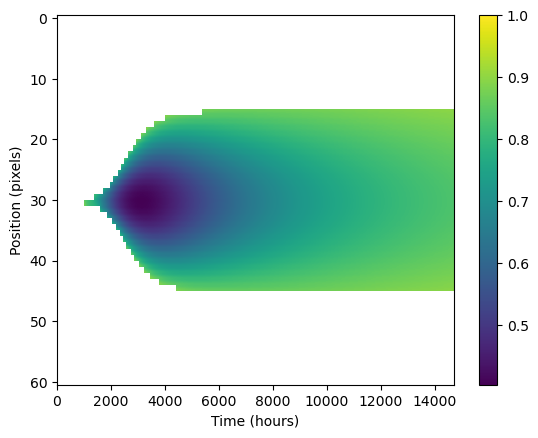

In [28]:
plt.imshow(umask[:,int(nx//2),:].transpose(), aspect='auto') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()
#plt.contour(u[10:,int(nx//2),:].transpose(), [0.025])
plt.xlabel('Time (hours)')
plt.ylabel('Position (pixels)')

In [29]:
np.save(os.path.join(path_results,'diff_pmask_fp_only.npy'),pmask) # solution for gene expression
np.save(os.path.join(path_results,'diff_p_fp_only.npy'),p) # p = pmask[:-1:120,:,:,:]
np.save(os.path.join(path_results,'diff_umask_fp_only.npy'),umask) # solution for dilution
np.save(os.path.join(path_results,'diff_uu_fp_only.npy'),uu) # uu = umask[:-1,:,:]
np.save(os.path.join(path_results,'diff_mrho_fp_only.npy'),mrho) # model
np.save(os.path.join(path_results,'diff_mdslrho_fp_only.npy'),mdslrho) # model
np.save(os.path.join(path_results,'diff_rho_01_fp_only.npy'),rho) # data
np.save(os.path.join(path_results,'diff_dslrho_01_fp_only.npy'),dslrho) # data

In [30]:
print(f'ha = {ha}')
print(f'K = {K0,K1,K2}')
print(f'alpha0,alpha1 = {alpha0,alpha1}')
print(f'beta = {beta0,beta1,beta2,beta3}')
print(f'KK0 = {KK0}')
print(f'KK1 = {KK1}')
print(f'KK2 = {KK2}')
print(f'KK3 = {KK3}')
print(f'nn = {nn}')
print(f'kappa, gamma = {kappa,gamma}')
print(f'rep0 = {rep00, rep01, rep02}')
print(f'Repressor half life = {np.log(2) / gamma_repr / 60} mins')
print(f'FP0 half life = {np.log(2) / gamma_fp0 / 60 / 60} hrs')
print(f'FP1 half life = {np.log(2) / gamma_fp1 / 60 / 60} hrs')

ha = 0.6308472337935569
K = (1.0074707530643978e-06, 177.89949890176905, 0.15756902265777067)
alpha0,alpha1 = (0.35594170274357195, 5.542125229076038)
beta = (0.001, 0.001, 0.0485273592235571, 1.9048729634527275)
KK0 = 1
KK1 = 1
KK2 = 0.7222224928226467
KK3 = 0.7036016774817896
nn = 66.30643214235589
kappa, gamma = (2.290168926838198e-13, 0.47449169836674837)
rep0 = (977902.2195427327, 1.00084978781158e-06, 476.08992439814256)
Repressor half life = 20.93380242488562 mins
FP0 half life = 10.14078992008654 hrs
FP1 half life = 0.8228780366612266 hrs


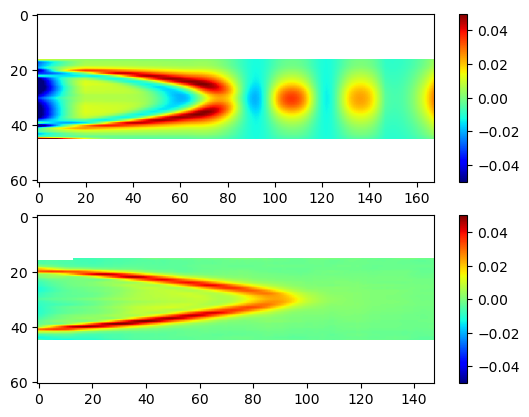

In [31]:
plt.subplot(2, 1, 1)
plt.imshow(mdslrho[:,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.05, vmax=0.05) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

idx0 = int(8 * 60 * 60 // dt // 60)
idx1 = int(36 * 60 * 60 // dt // 60)

plt.subplot(2, 1, 2)
plt.imshow(dslrho[idx0+20:idx1,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.05, vmax=0.05) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

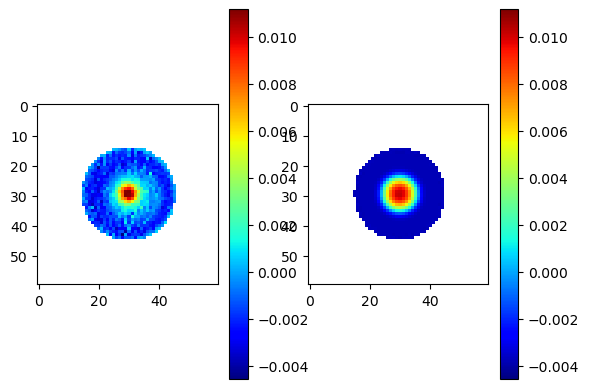

In [400]:
tpt = 50
vmin = np.nanmin(dslrho[idx1-tpt,:,:])
vmax = np.nanmax(dslrho[idx1-tpt,:,:])
plt.subplot(1, 2, 1)
plt.imshow(dslrho[idx1-tpt,:,:].transpose(), aspect='equal', cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(mdslrho[-tpt,:,:].transpose(), aspect='equal', cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar()

/home/guillermo/anaconda3/envs/popdyn/lib/python3.11/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


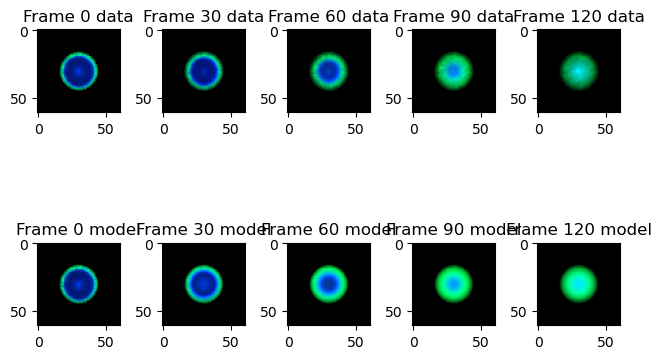

In [33]:
tidxs = [0, 30, 60, 90, 120]
ntidx = len(tidxs)
fig,axs = plt.subplots(2, ntidx)
for i in range(ntidx):
    tidx = tidxs[i]

    cim = np.zeros((nx,ny,3))
    cim1 = crop_im[idx0+tidx,:,:,0]
    cim1 = (cim1 - np.nanmin(cim1)) / (np.nanmax(cim1) - np.nanmin(cim1))
    cim2 = crop_im[idx0+tidx,:,:,1]
    cim2 = (cim2 - np.nanmin(cim2)) / (np.nanmax(cim2) - np.nanmin(cim2))
    cim[:,:,1] = cim1
    cim[:,:,2] = cim2
    axs[0,i].imshow(cim, aspect='equal')
    axs[0,i].set_title(f'Frame {tidx} data')

    cim = np.zeros((nx,ny,3))
    cim1 = p[tidx,:,:,3]
    cim1 = (cim1 - np.nanmin(cim1)) / (np.nanmax(cim1) - np.nanmin(cim1))
    cim2 = p[tidx,:,:,4]
    cim2 = (cim2 - np.nanmin(cim2)) / (np.nanmax(cim2) - np.nanmin(cim2))
    cim[:,:,1] = cim1
    cim[:,:,2] = cim2
    axs[1,i].imshow(cim, aspect='equal')
    axs[1,i].set_title(f'Frame {tidx} model')
plt.tight_layout()

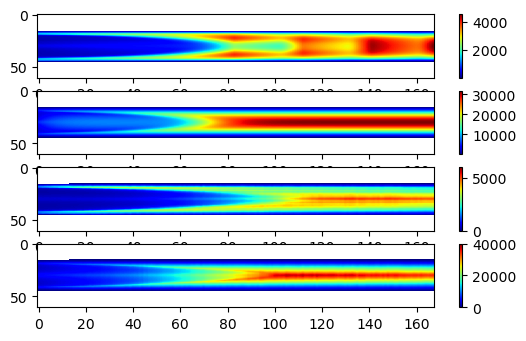

In [34]:
plt.subplot(5, 1, 1)
plt.imshow(p[:,int(nx//2),:,3].transpose(), aspect='auto', cmap='jet') #, vmin=0, vmax=360)
plt.colorbar()
plt.subplot(5, 1, 2)
plt.imshow(p[:,int(nx//2),:,4].transpose(), aspect='auto', cmap='jet') #, vmin=0, vmax=4e4)
plt.colorbar()
plt.subplot(5, 1, 3)
plt.imshow(crop_im[idx0:idx1,int(nx//2),:,0].transpose(), aspect='auto', cmap='jet', vmin=0, vmax=6e3)
plt.colorbar()
plt.subplot(5, 1, 4)
plt.imshow(crop_im[idx0:idx1,int(nx//2),:,1].transpose(), aspect='auto', cmap='jet', vmin=0, vmax=4e4)
plt.colorbar()

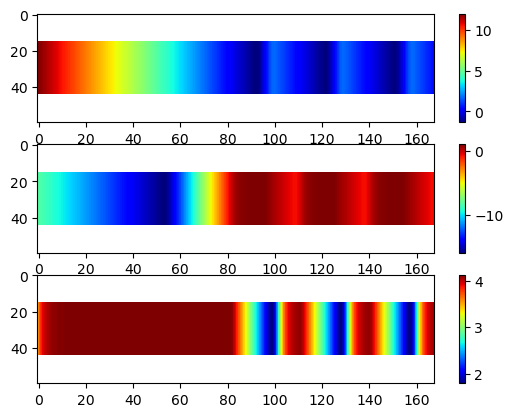

In [31]:
plt.subplot(3, 1, 1)
plt.imshow(np.log10(p[:,int(nx//2),:,0].transpose()/K0), aspect='auto', cmap='jet') #, vmin=0, vmax=100*K0)
plt.colorbar()
plt.subplot(3, 1, 2)
plt.imshow(np.log10(p[:,int(nx//2),:,1].transpose()/K1), aspect='auto', cmap='jet') #, vmin=0, vmax=100*K1)
plt.colorbar()
plt.subplot(3, 1, 3)
plt.imshow(np.log10(p[:,int(nx//2),:,2].transpose()/K2), aspect='auto', cmap='jet') #, vmin=0, vmax=100*K2)
plt.colorbar()


#### From file

In [2]:
import numpy as np
import os
from skimage.io import imread
from scipy.ndimage import laplace
import matplotlib.pyplot as plt

In [3]:
#path_ext = '/Users/timrudge/Pictures/Analyzed files' # 
path_ext = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files'
folder_results = 'results'
folder_velocity = 'velocity_data'

scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
dnas = {'pLPT20&pLPT41': 'pLPT20&41', 'pLPT119&pLPT41': 'pLPT119&41', 'pAAA': 'pAAA', 'pLPT107&pLPT41': 'pLPT107&41'}

exp_date = '2023_12_08'
#vector = 'pAAA'
#vector = 'pLPT107&pLPT41'
vector = 'pLPT20&pLPT41'
#vector = 'pLPT119&pLPT41'

#scope_name = 'Ti scope'
scope_name = 'Tweez scope'
pos = 12

if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
    yfp_chn = 0
    cfp_chn = 1
    ph_chn = 2
    fluo_chns = 2
else:
    rfp_chn = 0
    yfp_chn = 1
    cfp_chn = 2
    ph_chn = 3
    fluo_chns = 3

path_scope = os.path.join(path_ext, scope_name)
path = os.path.join(path_scope, exp_date)
path_results = os.path.join(path,folder_results, f"pos{pos}")
path_velocity = os.path.join(path,folder_velocity, f"pos{pos}")

fname = f'{exp_date}_10x_1.0x_{dnas[vector]}_{scopes[scope_name]}_Pos{pos}.ome.tif'
fname

'2023_12_08_10x_1.0x_pLPT20&41_TiTweez_Pos12.ome.tif'

In [4]:
area_all = np.load(os.path.join(path_results,'diff_area_all_fp_only.npy')) # area
pmask = np.load(os.path.join(path_results,'diff_pmask_fp_only.npy')) # solution for gene expression
p = np.load(os.path.join(path_results,'diff_p_fp_only.npy')) # p = pmask[:-1:120,:,:,:]
umask = np.load(os.path.join(path_results,'diff_umask_fp_only.npy')) # solution for dilution
uu = np.load(os.path.join(path_results,'diff_uu_fp_only.npy')) # uu = umask[:-1,:,:]
mrho = np.load(os.path.join(path_results,'diff_mrho_fp_only.npy')) # model
mdslrho = np.load(os.path.join(path_results,'diff_mdslrho_fp_only.npy')) # model
rho_01 = np.load(os.path.join(path_results,'diff_rho_01_fp_only.npy')) # data
dslrho_01 = np.load(os.path.join(path_results,'diff_dslrho_01_fp_only.npy')) # data
crop_edt = np.load(os.path.join(path_results, 'diff_crop_edt_fp_only.npy'))
crop_im = np.load(os.path.join(path_results, 'diff_crop_im_fp_only.npy'))

In [6]:
ntt,nx,ny = crop_edt.shape
nt,nx,ny,nc = crop_im.shape
dt = 10
edt = np.load(os.path.join(path_results,'edt.npy'))
ylim = (edt.max() + 16) * 1.35
ylim

340.2514788919079

#### Diffusion solution

In [7]:
def plot_diffusion(ylim, area_all, shift, umask, nx,ymin, ymax, rad_shift,filename, tfin):
    ## GET THE SHIFT CORRECT !
    plt.figure(figsize=(9,4.2))
    #ylim = (edt.max() + 16) * 1.35
    rad_blocks = np.sqrt(area_all / np.pi) / 16
    #shift = 0
    tf = umask[shift:, int(nx // 2), ymin:ymax].shape[0]
    
    # Plot the image
    plt.imshow(umask[shift:, int(nx // 2), ymin:ymax].transpose(), aspect='auto', cmap='jet',vmin=0, vmax=1)
    
    # Plot the overlaid lines
    plt.plot(np.linspace(0, tf, num=len(rad_blocks)), rad_blocks + rad_shift, '--k')
    plt.plot(np.linspace(0, tf, num=len(rad_blocks)), -rad_blocks + rad_shift, '--k')
    
    # Add the colorbar
    plt.colorbar()
    
    # Add title and labels with the specified font sizes
    plt.title('Diffusion field solution', fontsize=18)  # Title with fontsize 18
    plt.xlabel('Time [h]', fontsize=16)  # X label fontsize 14
    plt.ylabel('Radial distance [$\mu m$]', fontsize=16)  # Y label fontsize 14
    
    # Set the y-tick positions and labels to limit the number of points shown
    ytick_positions = np.linspace(0, umask[shift:, int(nx // 2), ymin:ymax].shape[1]-1, num=5)  # Limit to 5 ticks
    
    plt.yticks(ytick_positions, labels=np.linspace(-ylim, ylim, num=5).astype(int), fontsize=16)  # Set labels and fontsize 14 for y-ticks
    plt.gca().invert_yaxis()
    # Now set the x-ticks correctly
    # Calculate the time shift in hours
    time_shift_hours = (shift * dt) / 3600
    
    # Set the xtick positions to match the pixel positions
    xtick_positions = np.linspace(0, tf, num=6)  # Generate tick positions based on the pixel index range
    xtick_labels = np.linspace(time_shift_hours, tfin, num=6, dtype=int)  # Set labels from time shift to 32 hours
    
    plt.xticks(xtick_positions, labels=xtick_labels, fontsize=16)  # Apply the tick positions and labels, fontsize 14 for x-ticks
    
    # Set the x-axis limits to match the range of the data (prevent extra white space)
    plt.xlim(0, tf)  # Restrict x-axis to the data range
    
    plt.tight_layout()
    plt.savefig(filename,dpi=300)
    plt.show()

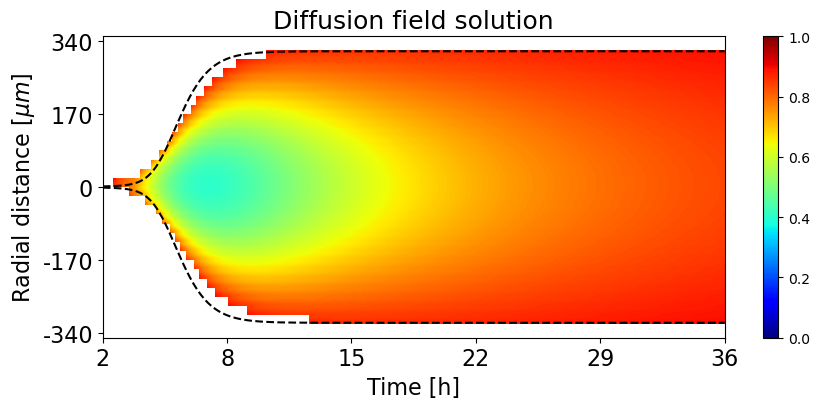

In [8]:
#"""
# pLPT20
ymin = 14
ymax = 47
rad_shift = 16
shift = 750
filename = 'pLPT20_diff_field_fp_only.png'
tfin = 36
#"""
plot_diffusion(ylim, area_all, shift, umask, nx, ymin, ymax, rad_shift,filename, tfin)

#### Fluo levels

In [9]:
incubation_time = 4.8166 * 60 * 60 # pos 12
offset = incubation_time / 60 / 10

idx0 = int(8 * 60 * 60 // dt // 60)
idx1 = int(36 * 60 * 60 // dt // 60)
tini = 8

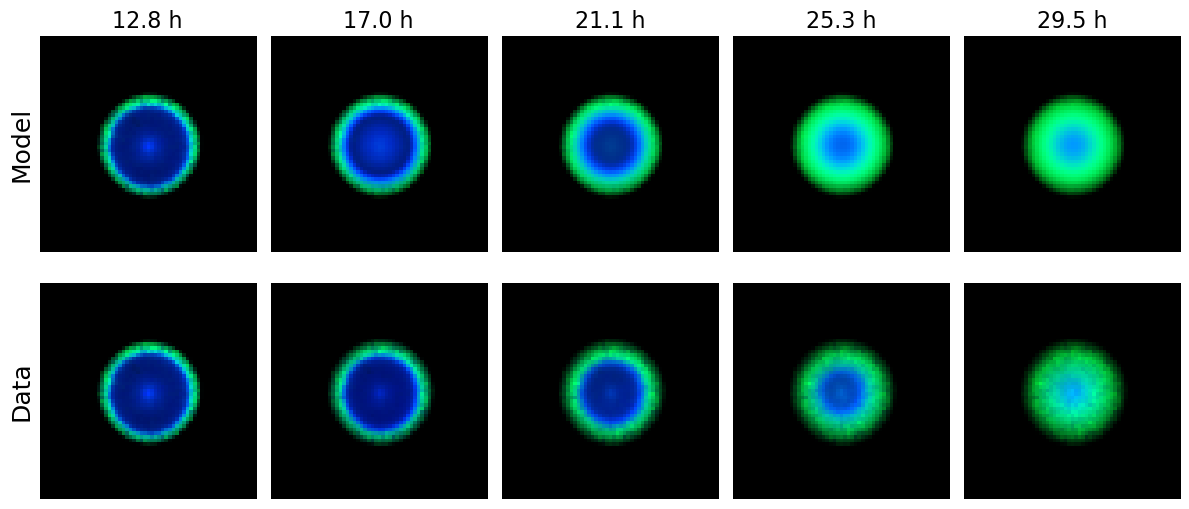

In [11]:
tidxs = [0, 25, 50, 75, 100]
ntidx = len(tidxs)
fig, axs = plt.subplots(2, ntidx, figsize=(12, 8))

for i in range(ntidx):
    tidx = tidxs[i]
    hours = incubation_time / 60 / 60 + tini + tidx * 10 / 60 

    # Model
    cim = np.zeros((nx,ny,3))
    cim1 = p[tidx,:,:,3]
    cim1 = (cim1 - np.nanmin(cim1)) / (np.nanmax(cim1) - np.nanmin(cim1))
    cim2 = p[tidx,:,:,4]
    cim2 = (cim2 - np.nanmin(cim2)) / (np.nanmax(cim2) - np.nanmin(cim2))
    cim[:,:,1] = cim1
    cim[:,:,2] = cim2
    axs[0,i].imshow(cim, aspect='equal')
    axs[0,i].set_title(f'{round(hours, 1)} h', fontsize=16)

    # Data
    cim = np.zeros((nx,ny,3))
    cim1 = crop_im[idx0+tidx,:,:,0]
    cim1 = (cim1 - np.nanmin(cim1)) / (np.nanmax(cim1) - np.nanmin(cim1))
    cim2 = crop_im[idx0+tidx,:,:,1]
    cim2 = (cim2 - np.nanmin(cim2)) / (np.nanmax(cim2) - np.nanmin(cim2))
    cim[:,:,1] = cim1
    cim[:,:,2] = cim2
    axs[1,i].imshow(cim, aspect='equal')
    #axs[1,i].set_title(f'{round(hours, 1)} h')

    # Remove ticks and spines for a cleaner look
    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[0,i].spines['top'].set_visible(False)
    axs[0,i].spines['bottom'].set_visible(False)
    axs[0,i].spines['left'].set_visible(False)
    axs[0,i].spines['right'].set_visible(False)
    
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])
    axs[1,i].spines['top'].set_visible(False)
    axs[1,i].spines['bottom'].set_visible(False)
    axs[1,i].spines['left'].set_visible(False)
    axs[1,i].spines['right'].set_visible(False)

# Add y-axis labels only for the first subplot in each row
axs[0, 0].set_ylabel('Model', fontsize=18)
axs[1, 0].set_ylabel('Data', fontsize=18)

# Adjust layout to reduce spaces between the subplots
plt.subplots_adjust(wspace=80, hspace=0.1)

# Call tight_layout to ensure proper spacing
plt.tight_layout()
plt.savefig('pLPT20_fluo_model_data_fp_only.png', bbox_inches='tight')

#### Mean fluo kymos

In [12]:
## YFP channel in p = 3
## CFP channel in p = 4
fini = 48
fend = 216

##### Kymo image

In [13]:
im_all = crop_im[:,:,:,0]
# Assuming im_all is your image stack of shape (216, 37, 37)
nt, nx, ny = im_all.shape

# Calculate the radial distances for all pixels from the center of the image
x_center = nx // 2
y_center = ny // 2
y, x = np.ogrid[:ny, :nx]
radii = np.sqrt((x - x_center)**2 + (y - y_center)**2)

# Define the radial bands (you can adjust the range if needed)
rs = np.arange(1, im_all.shape[1] // 2)  # Radial distances (from 1 to 18)

# Initialize an array to store the mean intensity for each band over time
imrmean = np.zeros((nt, len(rs))) + np.nan

# Loop over each time point and calculate the mean for each radial band
for t in range(nt):
    for i, r in enumerate(rs):
        # Get the pixels that fall within the current radial band
        mask = (radii >= r - 0.5) & (radii < r + 0.5)
        
        # Extract the corresponding pixel values from the image
        pixels_in_band = im_all[t, mask]
        
        # Calculate the mean for the radial band, ignoring NaNs
        if len(pixels_in_band) > 0:
            imrmean[t, i] = np.nanmean(pixels_in_band)

# Now, rmean contains the kymograph: time (216) by radial distance (19)

/tmp/ipykernel_15913/3149209224.py:28: RuntimeWarning: Mean of empty slice
  imrmean[t, i] = np.nanmean(pixels_in_band)


##### Kymo model

In [14]:
im_all = pmask[:,:,:,3]
nt,nx,ny = im_all.shape
# Assuming im_all is your image stack of shape (216, 37, 37)
#nt = 192
nt = fend
# Calculate the radial distances for all pixels from the center of the image
x_center = nx // 2
y_center = ny // 2
y, x = np.ogrid[:ny, :nx]
radii = np.sqrt((x - x_center)**2 + (y - y_center)**2)

# Define the radial bands (you can adjust the range if needed)
rs = np.arange(1, nx // 2)  # Radial distances (from 1 to 18)

# Initialize an array to store the mean intensity for each band over time
mrmean = np.zeros((nt, len(rs))) + np.nan

# Loop over each time point and calculate the mean for each radial band

tbase = 48
#tim = 100

for tim in range(tbase,nt):
    tmodel = int((tim - tbase) * 60 * 10 / dt)
    t = tmodel
    for i, r in enumerate(rs):
        # Get the pixels that fall within the current radial band
        mask = (radii >= r - 0.5) & (radii < r + 0.5)
        
        # Extract the corresponding pixel values from the image
        pixels_in_band = im_all[t, mask]
        
        # Calculate the mean for the radial band, ignoring NaNs
        if len(pixels_in_band) > 0:
            mrmean[tim, i] = np.nanmean(pixels_in_band)

# Now, rmean contains the kymograph: time (216) by radial distance (19)

/tmp/ipykernel_15913/969895979.py:35: RuntimeWarning: Mean of empty slice
  mrmean[tim, i] = np.nanmean(pixels_in_band)


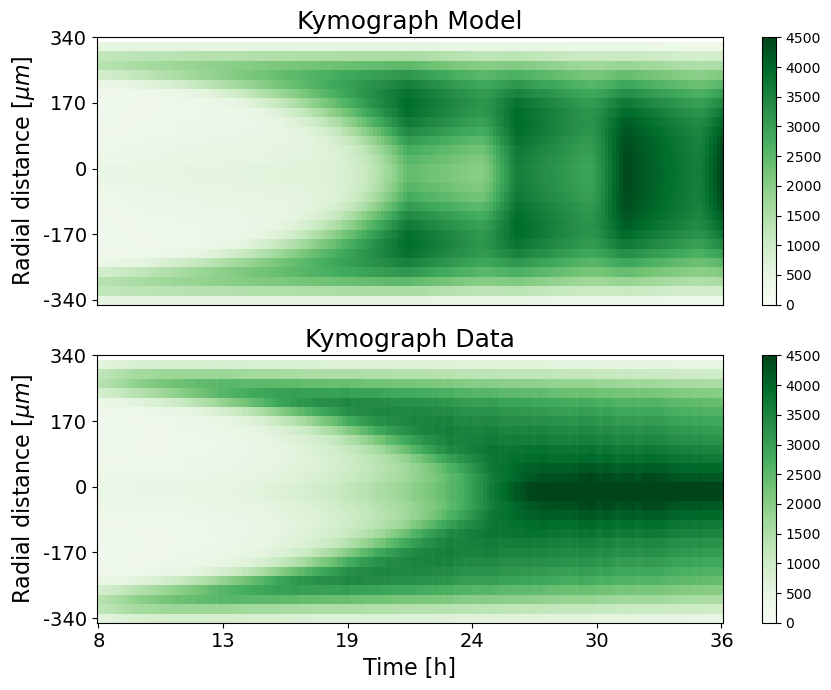

In [16]:
#ymin = 12
#ymax = 46
ymin = 15
ymax = 43
plt.figure(figsize=(9, 7))  # Create a figure with the adjusted size for both plots

# First subplot: Kymograph Image
plt.subplot(2, 1, 1)  # 2 rows, 1 column, second subplot
mkymograph = np.hstack([mrmean[:, ::-1], mrmean[:, :]])
plt.imshow(mkymograph.T[ymin:ymax, fini:], aspect='auto', cmap='Greens',vmin=0,vmax=4500)
plt.title('Kymograph Model', fontsize=18)
plt.ylabel('Radial distance [$\mu m$]', fontsize=16) 
plt.colorbar()
plt.xticks([])  # Remove x-ticks for the top plot
plt.yticks(np.linspace(0, mdslrho[:, int(nx // 2), ymin:ymax].shape[1], num=5), labels=np.linspace(-ylim, ylim, num=5).astype(int), fontsize=14)
plt.gca().invert_yaxis()  # Invert the y-axis

# Second subplot: Kymograph Model
plt.subplot(2, 1, 2)  # 2 rows, 1 column, first subplot
imkymograph = np.hstack([imrmean[:fend+1, ::-1], imrmean[:fend+1, :]])
plt.imshow(imkymograph.T[ymin:ymax, fini:], aspect='auto', cmap='Greens',vmin=0,vmax=4500)
plt.title('Kymograph Data', fontsize=18)
plt.colorbar()

# Set the x-ticks and labels
xtick_positions = np.linspace(0, idx1 - idx0, num=6)  # Generate tick positions for the whole range
xtick_labels = np.linspace(8, 36, num=6, dtype=int)  # Adjust labels accordingly
plt.xticks(xtick_positions, labels=xtick_labels, fontsize=14)  # X-ticks with fontsize 14
plt.yticks(np.linspace(0, dslrho_01[idx0:idx1, int(nx // 2), ymin:ymax].shape[1], num=5), labels=np.linspace(-ylim, ylim, num=5).astype(int), fontsize=14)  # Y-ticks using ylim, fontsize 14
plt.xlabel('Time [h]', fontsize=16)  # X-axis label font size 14
plt.ylabel('Radial distance [$\mu m$]', fontsize=16)  # Y-axis label font size 14
plt.gca().invert_yaxis()  # Invert the y-axis

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.savefig('pLPT20_kymo_fluo_model_data_fp_only.png', dpi=300)

#### Delta

In [17]:
# pLPT20 YFP
tini = 8 # initial time when wave starts hours
tfin = 36
fini = 48 # initial frame when wave starts
fend = 216 # frame when wave stops

ymin = 12
ymax = 44
dt = 10

vmin = -0.05
vmax = 0.05

In [18]:
mdslrho.shape

(168, 61, 61)

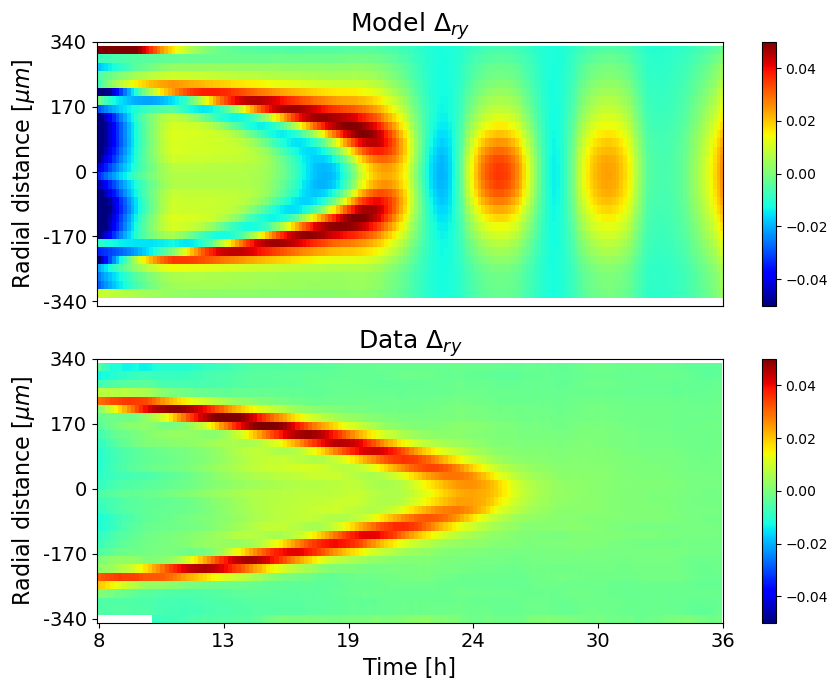

In [19]:
# pLPT20 YFP
tini = 8 # initial time when wave starts hours
tfin = 36
fini = 48 # initial frame when wave starts
fend = 216 # frame when wave stops

ymin = 15
ymax = 46
dt = 10

vmin = -0.05
vmax = 0.05
#plt.subplot(2, 1, 1)
#plt.imshow(mdslrho[:,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.05, vmax=0.05) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
#plt.colorbar()

plt.figure(figsize=(9,7))
ylim = (edt.max() +16)* 1.35  # New ylim calculation

# First subplot (Model)
plt.subplot(2, 1, 1)
plt.imshow(mdslrho[:, int(nx // 2), ymin:ymax].transpose(), aspect='auto', cmap='jet',origin='lower', vmin=vmin, vmax=vmax)
plt.title('Model $\Delta_{ry}$', fontsize=18)  # Title with fontsize 18
plt.colorbar()
plt.xticks([])  # Remove x-ticks for the top plot
plt.yticks(np.linspace(0, mdslrho[:, int(nx // 2), ymin:ymax].shape[1], num=5), labels=np.linspace(-ylim, ylim, num=5).astype(int), fontsize=14)  # Y-ticks using ylim, fontsize 14
plt.ylabel('Radial distance [$\mu m$]', fontsize=16)  # Y-axis label font size 14


idx0 = int(8 * 60 * 60 // dt // 60)
idx1 = int(36 * 60 * 60 // dt // 60)

#plt.subplot(2, 1, 2)
#plt.imshow(dslrho_01[idx0+20:idx1,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.05, vmax=0.05) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
#plt.colorbar()

# Second subplot (Data)
plt.subplot(2, 1, 2)
plt.imshow(dslrho_01[idx0+20:idx1, int(nx // 2), ymin:ymax].transpose(), aspect='auto', cmap='jet',origin='lower', vmin=vmin, vmax=vmax)
plt.title('Data $\Delta_{ry}$', fontsize=18)  # Title with fontsize 18
plt.colorbar()

# Set the x-ticks and labels
xtick_positions = np.linspace(0, idx1 - idx0-20, num=6)  # Generate tick positions for the whole range
xtick_labels = np.linspace(tini, tfin, num=6, dtype=int)  # Adjust labels accordingly
plt.xticks(xtick_positions, labels=xtick_labels, fontsize=14)  # X-ticks with fontsize 14
plt.yticks(np.linspace(0, dslrho_01[idx0+20:idx1, int(nx // 2), ymin:ymax].shape[1], num=5), labels=np.linspace(-ylim, ylim, num=5).astype(int), fontsize=14)  # Y-ticks using ylim, fontsize 14
plt.xlabel('Time [h]', fontsize=16)  # X-axis label font size 14
plt.ylabel('Radial distance [$\mu m$]', fontsize=16)  # Y-axis label font size 14

plt.tight_layout()
plt.savefig('pLPT20_delta_model_data_fp_only.png',dpi=300)

In [62]:
ha, kappa, gamma_fp0, gamma_fp1, alpha0, alpha1, beta2, beta3, gamma, K0, K1, K2, gamma_repr, rep00, rep01, rep02, KK2, KK3, nn = np.load(f'xopt_{vector}_{exp_date}_{scope_name}_pos{pos}_fp_only.npy')
print(f'ha = {ha}')
print(f'K = {K0,K1,K2}')
print(f'alpha0,alpha1 = {alpha0,alpha1}')
print(f'beta = {beta0,beta1,beta2,beta3}')
print(f'KK0 = {KK0}')
print(f'KK1 = {KK1}')
print(f'KK2 = {KK2}')
print(f'KK3 = {KK3}')
print(f'nn = {nn}')
print(f'kappa, gamma = {kappa,gamma}')
print(f'rep0 = {rep00, rep01, rep02}')
print(f'Repressor half life = {np.log(2) / gamma_repr / 60 / 60 } hrs')
print(f'FP0 half life = {np.log(2) / gamma_fp0 / 60 / 60} hrs')
print(f'FP1 half life = {np.log(2) / gamma_fp1 / 60 / 60} hrs')

ha = 0.6308472337935569
K = (1.0074707530643978e-06, 177.89949890176905, 0.15756902265777067)
alpha0,alpha1 = (0.35594170274357195, 5.542125229076038)
beta = (0.001, 0.001, 0.0485273592235571, 1.9048729634527275)
KK0 = 1
KK1 = 1
KK2 = 0.7222224928226467
KK3 = 0.7036016774817896
nn = 66.30643214235589
kappa, gamma = (2.290168926838198e-13, 0.47449169836674837)
rep0 = (977902.2195427327, 1.00084978781158e-06, 476.08992439814256)
Repressor half life = 0.348896707081427 hrs
FP0 half life = 10.14078992008654 hrs
FP1 half life = 0.8228780366612266 hrs
